In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cf
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean

Matplotlib is building the font cache; this may take a moment.


In [2]:
import graphufs

plt.style.use("graphufs.plotstyle")

/contrib2/Tim.Smith/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [3]:
def swap_dims(xds):

    if "prediction_timedelta" in xds.coords and "lead_time" not in xds.coords:
        xds = xds.rename({"prediction_timedelta": "lead_time"})
    
    xds["fhr"] = (xds.lead_time.astype(int) / 3600 / 1e9).astype(int)
    xds = xds.swap_dims({"lead_time": "fhr"})
    return xds

In [4]:
def open_dataset(*args, **kwargs):
    xds = xr.open_dataset(*args, **kwargs)
    xds = swap_dims(xds)
    return xds

In [5]:
def open_zarr(*args, **kwargs):
    xds = xr.open_zarr(*args, **kwargs)
    xds = swap_dims(xds)
    
    xds["valid_time"] = xds.time + xds.lead_time
    xds = xds.set_coords("valid_time")
    return xds

In [6]:
gds = open_zarr("/p1-evaluation/v1/validation/graphufs.240h.zarr/")
gdm = open_zarr("/p1-evaluation/gdm-v1/validation/graphufs_gdm.240h.zarr/")
gdm2 = open_zarr("/p1-evaluation/gdm-v2/validation/graphufs_gdm.240h.zarr/")

In [7]:
era = xr.open_zarr(
    "gs://weatherbench2/datasets/era5/1959-2023_01_10-full_37-1h-0p25deg-chunk-1.zarr",
    storage_options={"token": "anon"},
)
era = era.sel(
    time=slice(
        gds.time.isel(time=0).values,
        gds.valid_time.isel(time=-1, fhr=-1).values
    ),
    level=[100,500,850],
)

In [8]:
gds["10m_wind_speed"] = np.sqrt(gds["ugrd10m"]**2 + gds["vgrd10m"]**2)
gdm["10m_wind_speed"] = np.sqrt(gdm["ugrd10m"]**2 + gdm["vgrd10m"]**2)
gdm2["10m_wind_speed"] = np.sqrt(gdm2["ugrd10m"]**2 + gdm2["vgrd10m"]**2)
era["10m_wind_speed"] = np.sqrt(era["10m_u_component_of_wind"]**2 + era["10m_v_component_of_wind"]**2)

In [9]:
from graphufs.spatialmap import SpatialMap

In [10]:
mapper = SpatialMap()

In [16]:
gds.time[30]

<xarray.DataArray 'time' ()> Size: 8B
array('2022-02-03T21:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2022-02-03T21:00:00

In [25]:
gdm2.time[11]

<xarray.DataArray 'time' ()> Size: 8B
array('2022-02-07T06:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2022-02-07T06:00:00

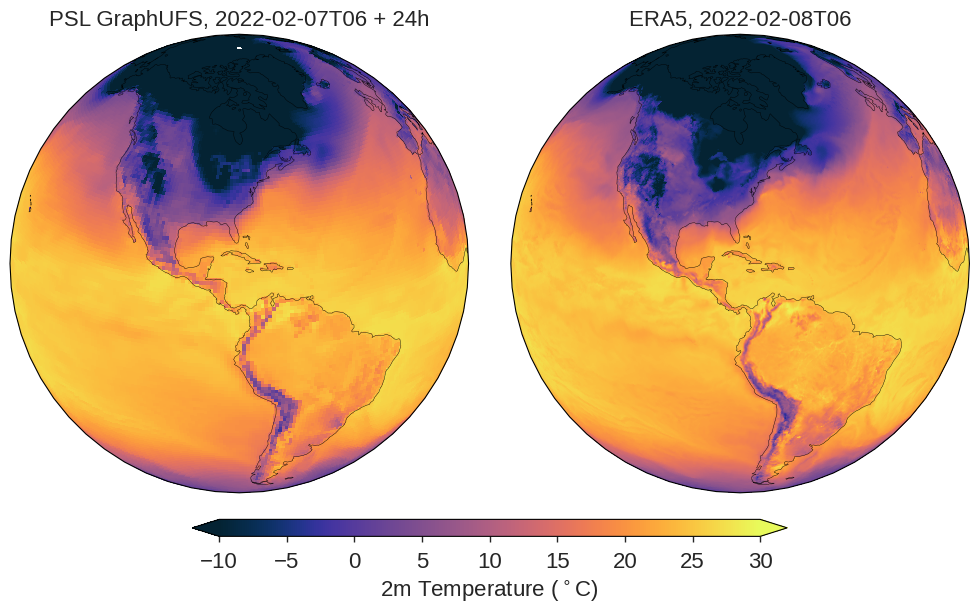

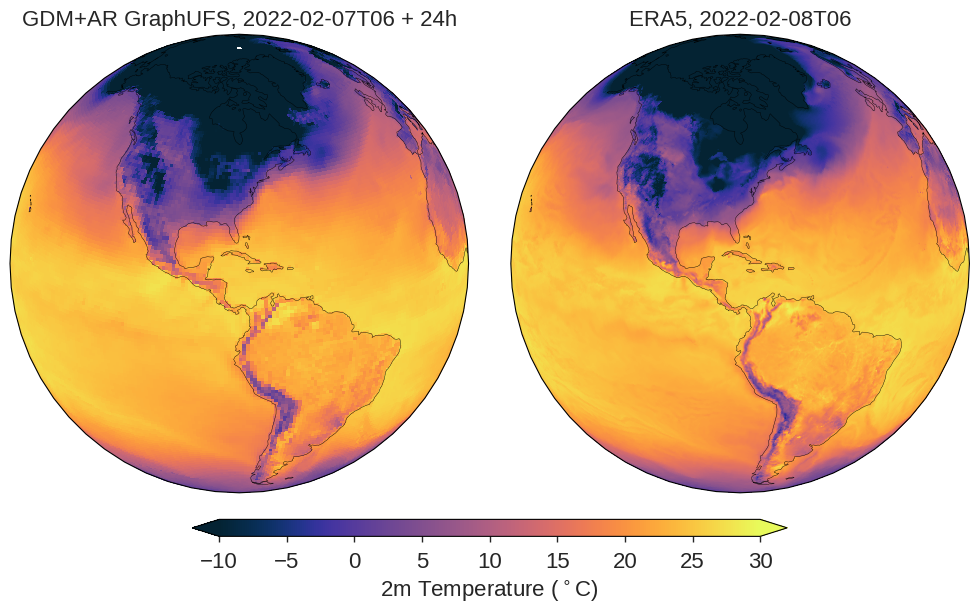

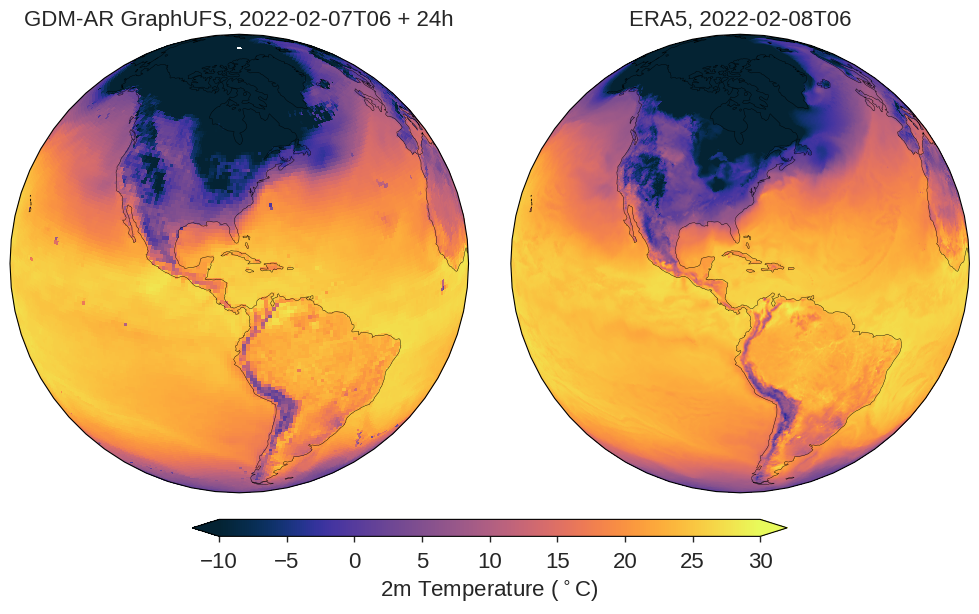

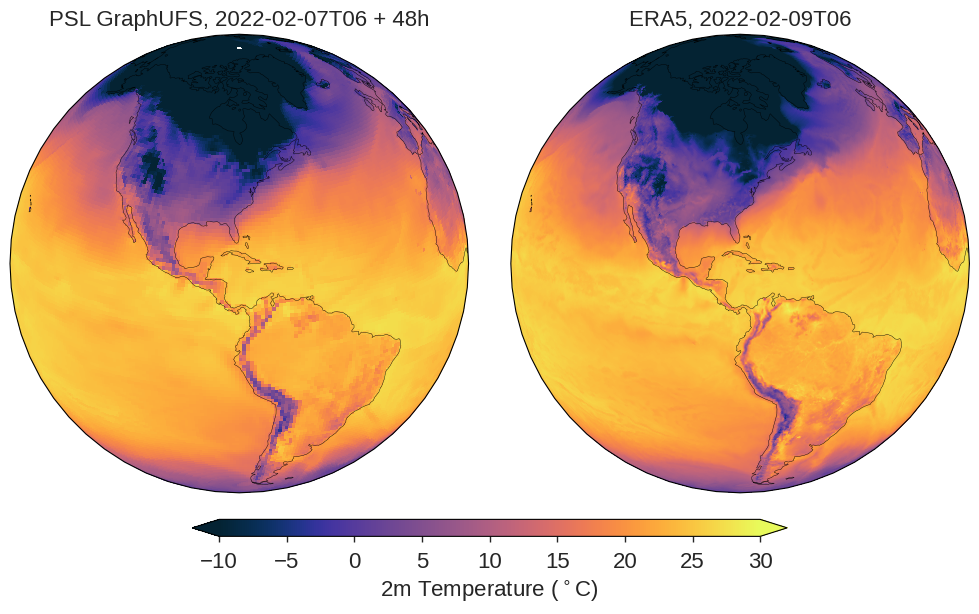

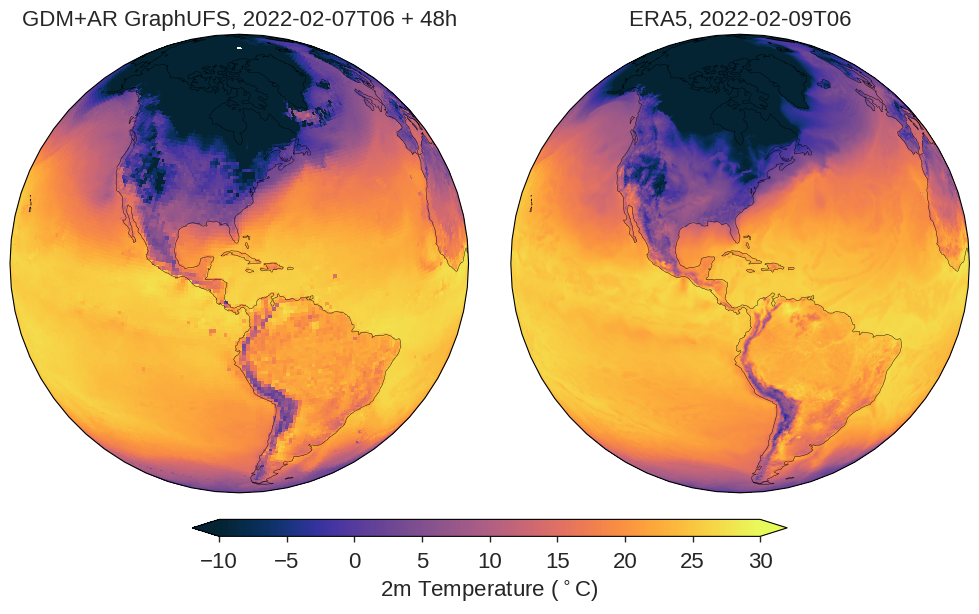

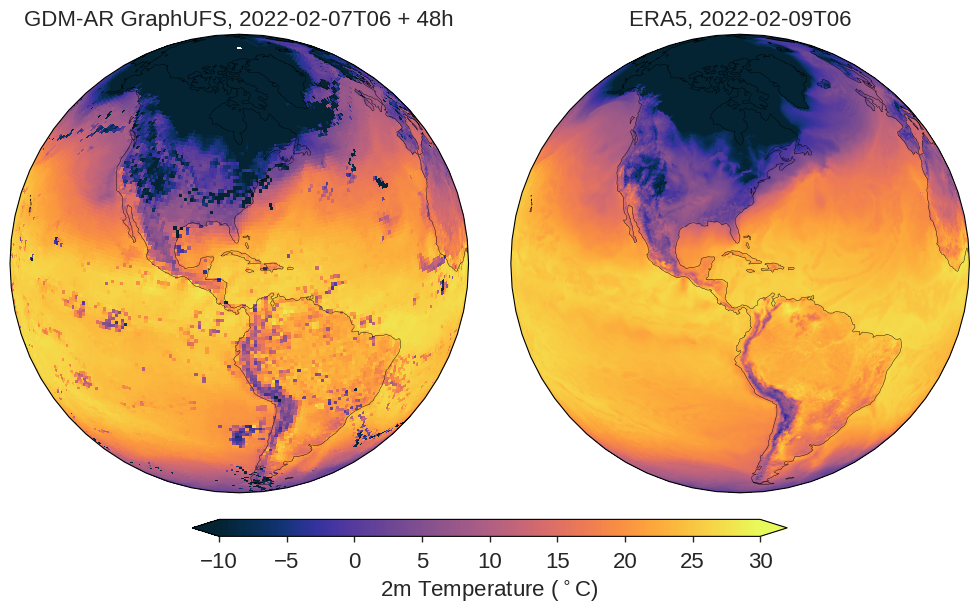

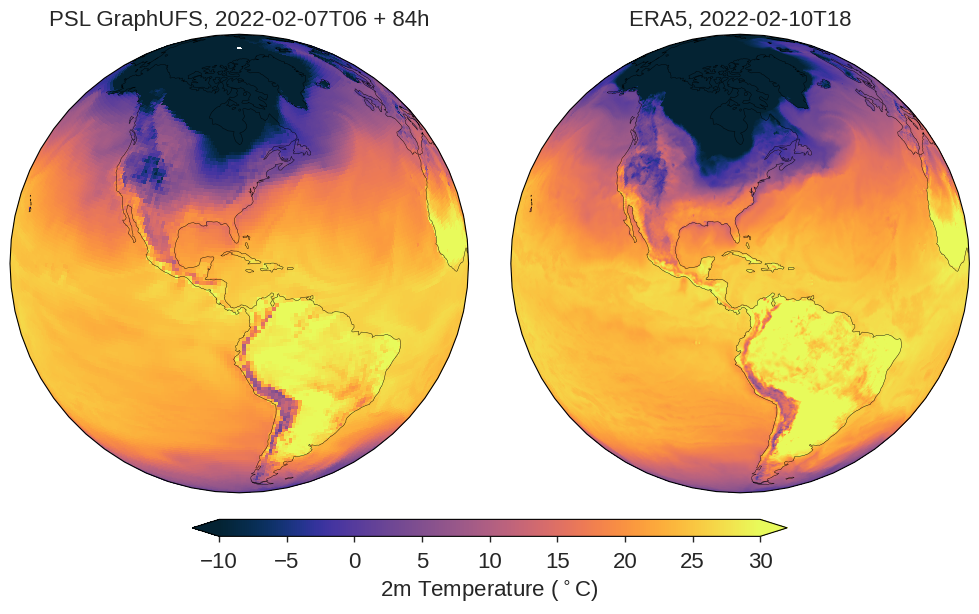

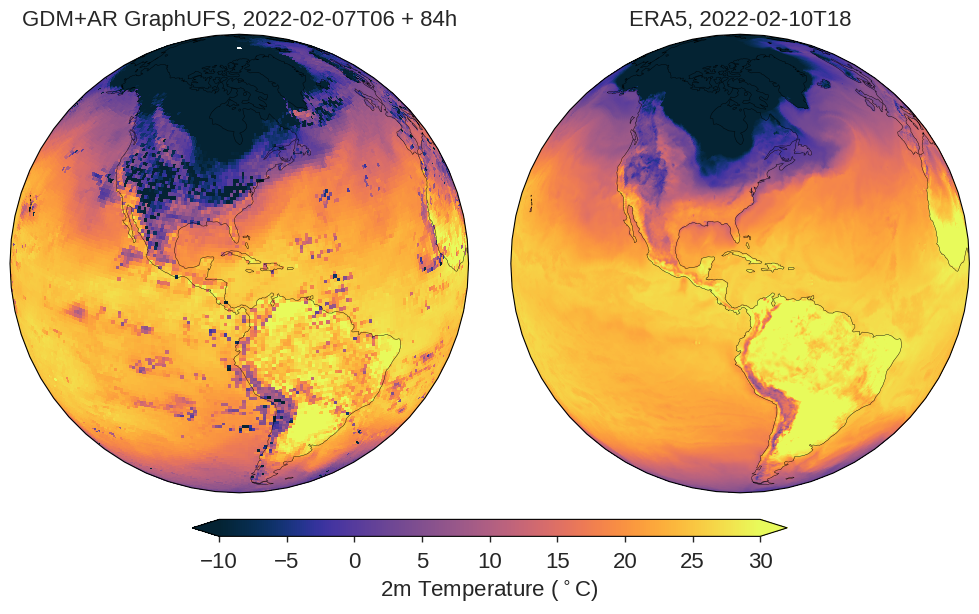

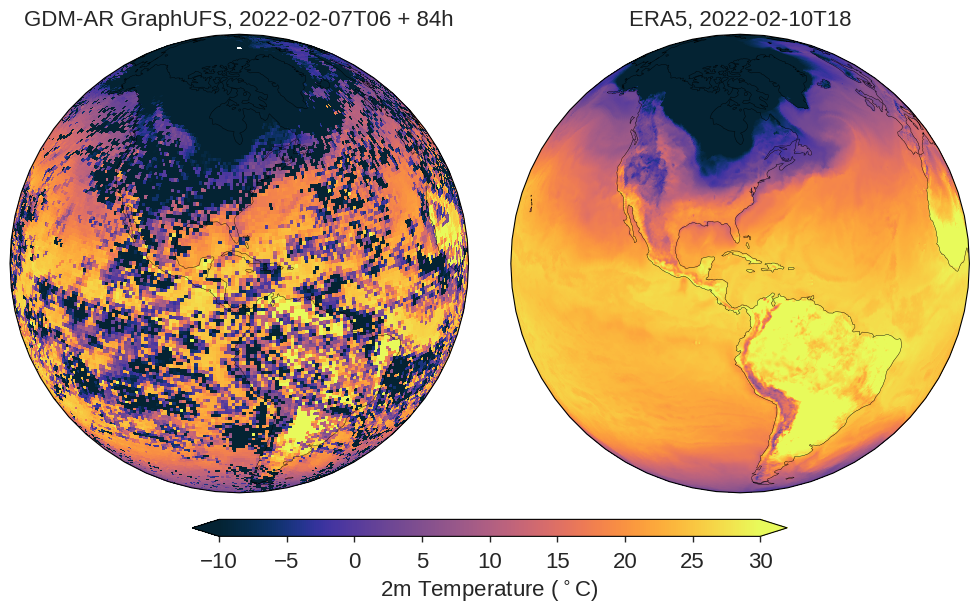

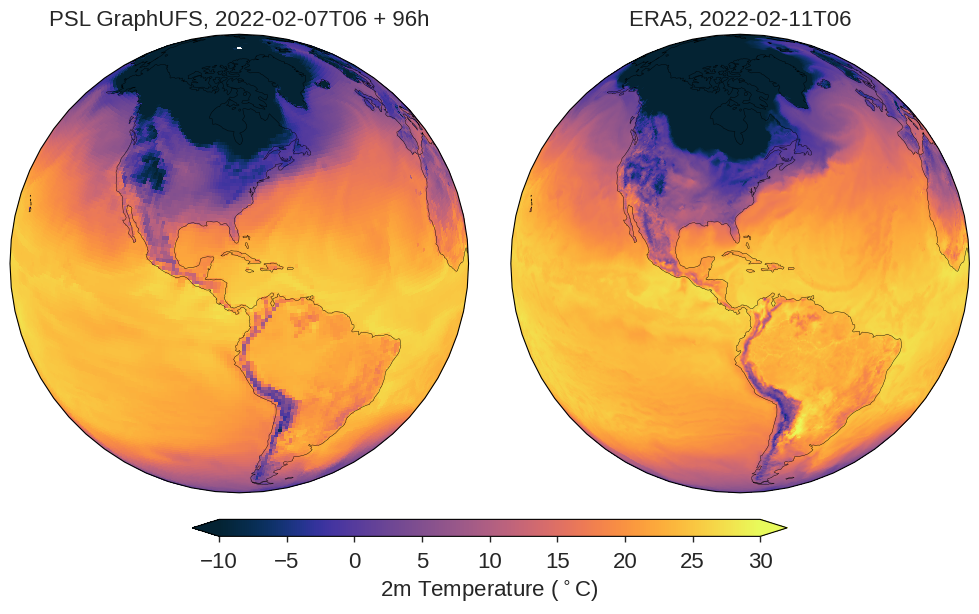

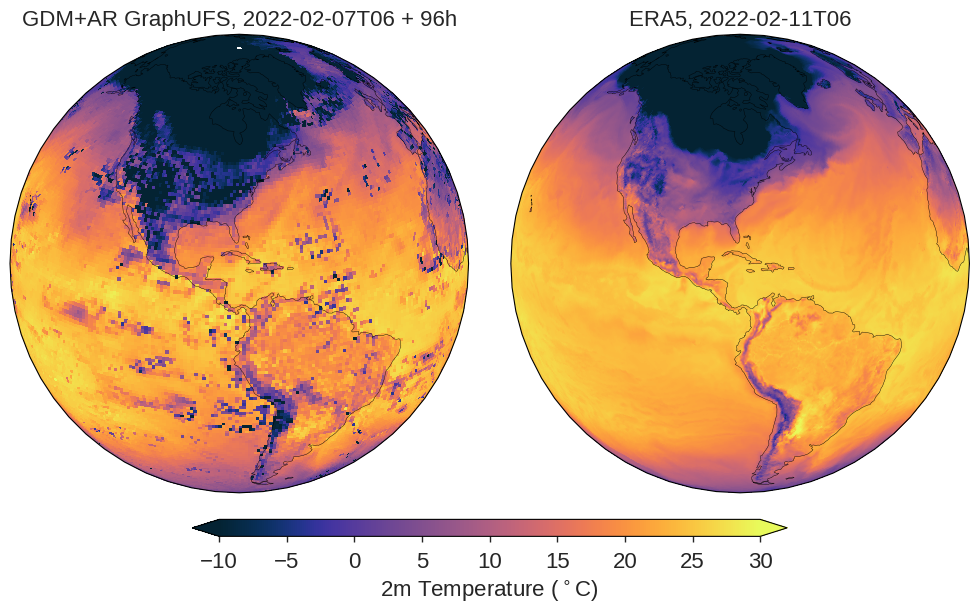

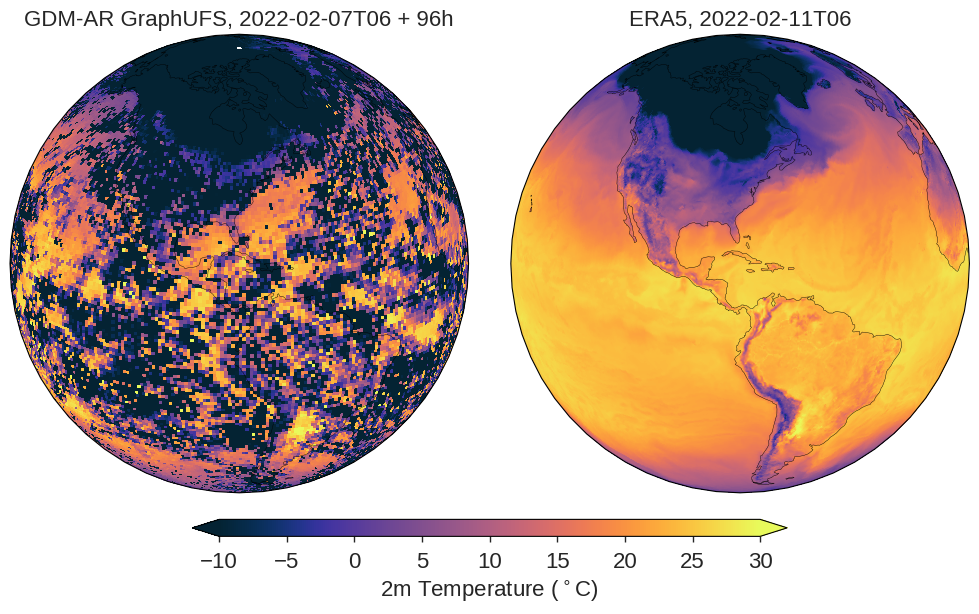

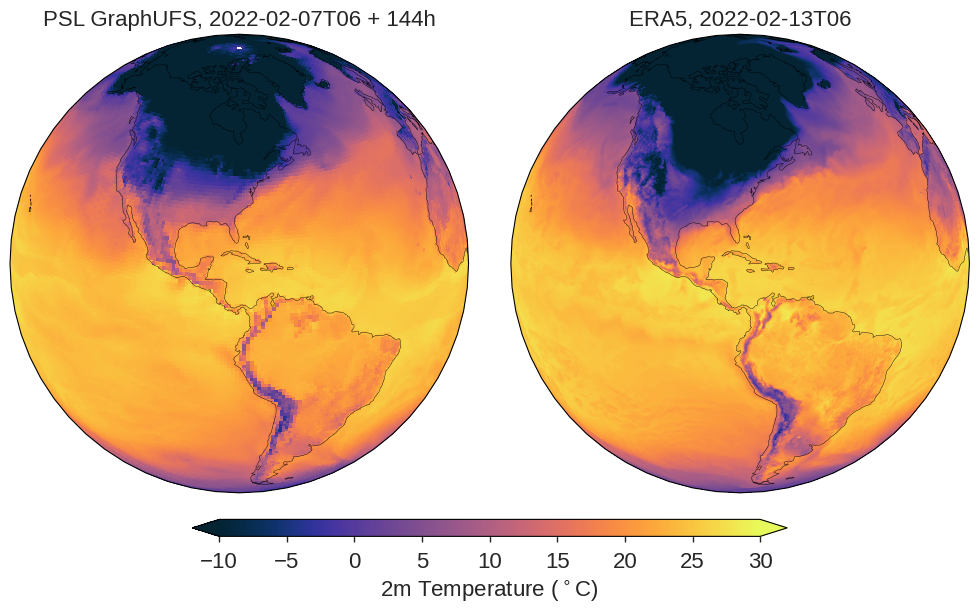

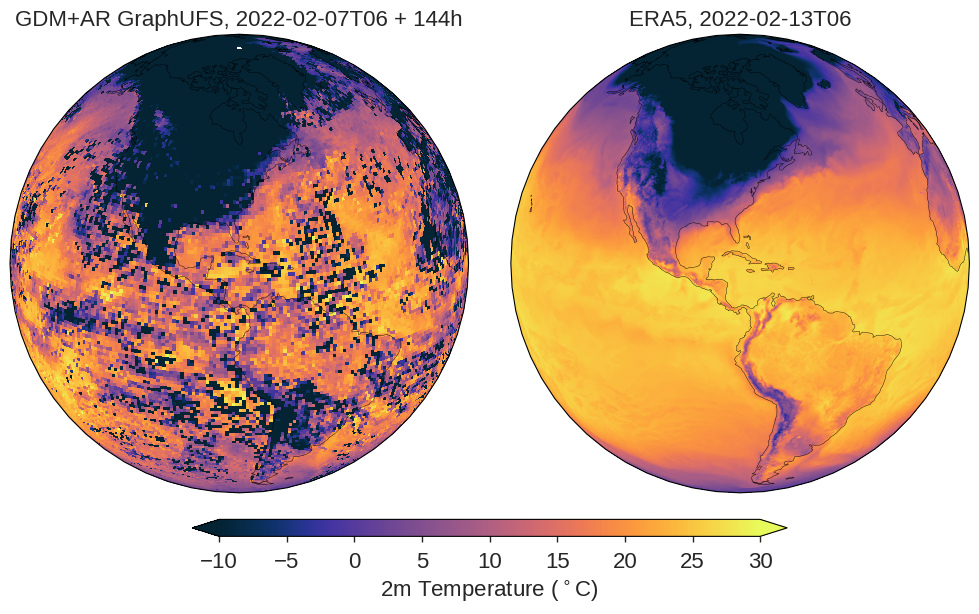

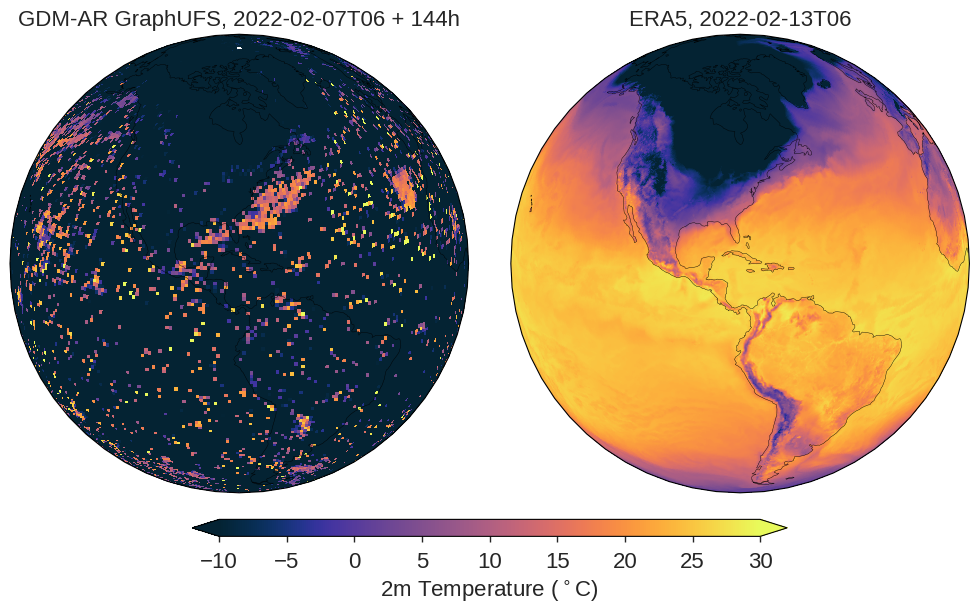

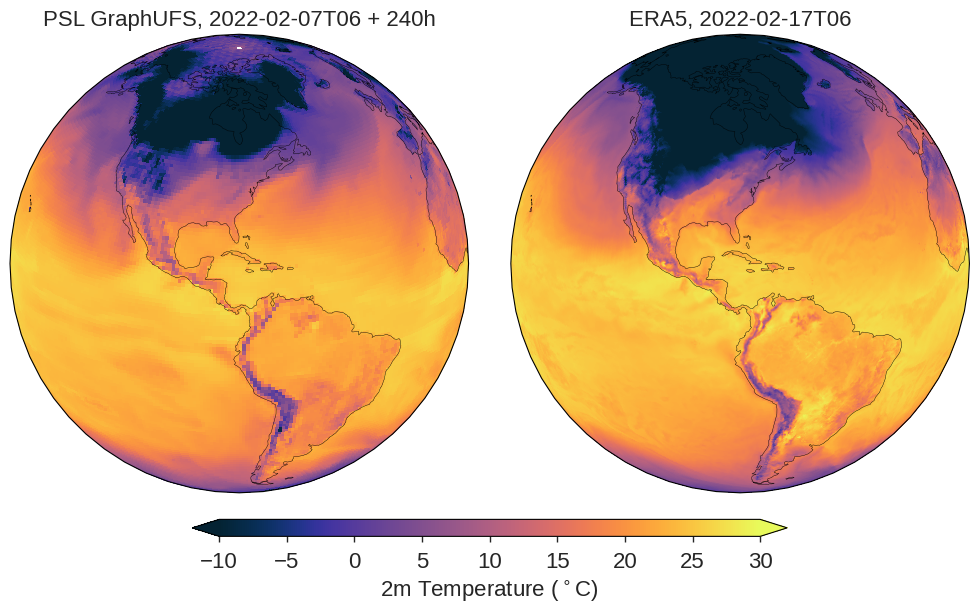

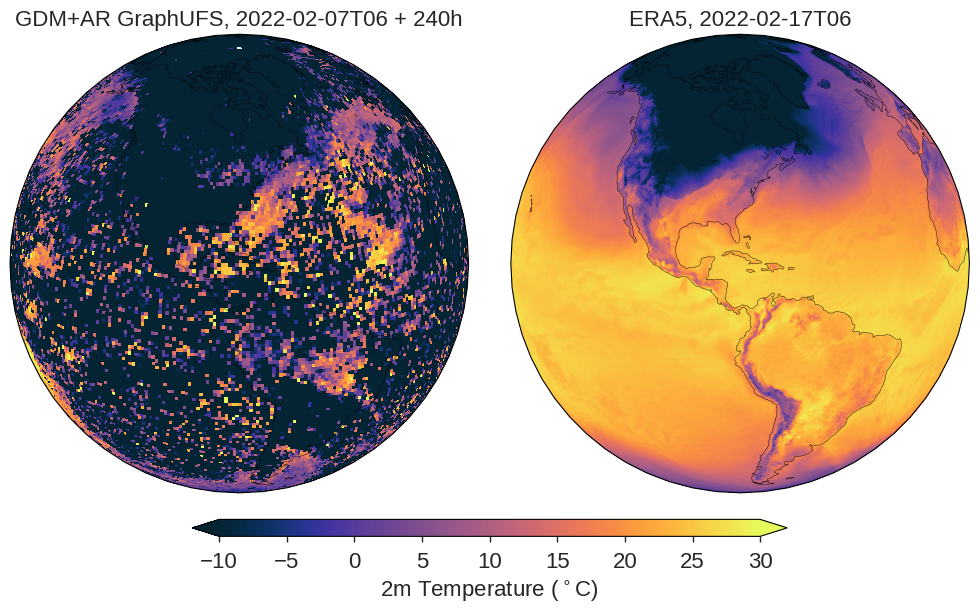

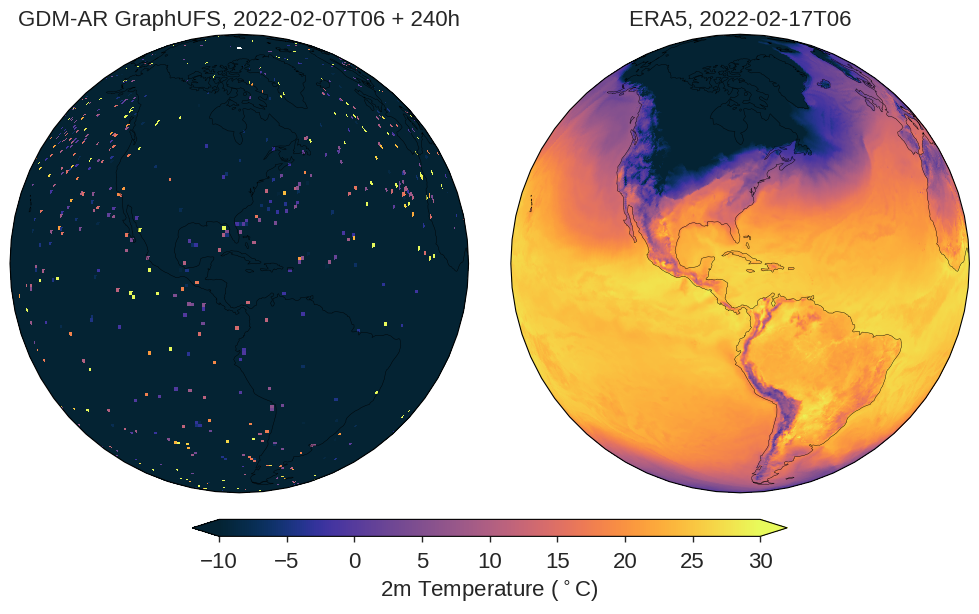

In [27]:
#date = "2022-07-21T12"
#date = "2022-02-09T12"
date = "2022-02-07T06"

gkey = "tmp2m"
ekey = "2m_temperature"
kw = {}

#gkey = "ugrd10m"
#ekey = "10m_u_component_of_wind"
#kw = {"cmap": "cmo.balance", "vmin": -20, "vmax": 20}

for fhr in [24, 24*2, 24*3 + 12, 24 * 4, 24 * 6, 24 * 10]:
    for xds, label  in zip([gds, gdm, gdm2], ["PSL", "GDM+AR", "GDM-AR"]):
        
        plotme = xds[gkey].sel(time=date, fhr=fhr)
        fig, axs = mapper.plot(
            plotme,
            era[ekey].sel(time=[plotme.valid_time.values]),
            **kw
        )
        axs[0].set(title=label+" "+axs[0].get_title())
        fig.savefig(f"figures/graphufs_{label.lower()}_and_era5_{gkey}_{fhr}h.jpeg", bbox_inches="tight", dpi=300)